**Library Declaration**

In [2]:
pip install tokenization

In [0]:
import gc
import re
import string
import operator
from collections import defaultdict

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import tokenization
from wordcloud import STOPWORDS

from sklearn.utils import resample
SEED = 1337


In [0]:
import gc
import re
import string
import operator
from collections import defaultdict

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import tokenization
from wordcloud import STOPWORDS

from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.utils import resample

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback

SEED = 1337

**Read all the csv files that we have collected using pandas.read_csv**

In [0]:
hot_posts = pd.read_csv('hotPosts.csv')
rising_posts = pd.read_csv('risingPosts.csv')
new_posts = pd.read_csv('newPosts.csv')
top_posts = pd.read_csv('topPosts.csv')


**Here, we try to visualize NULL present in our data.** 

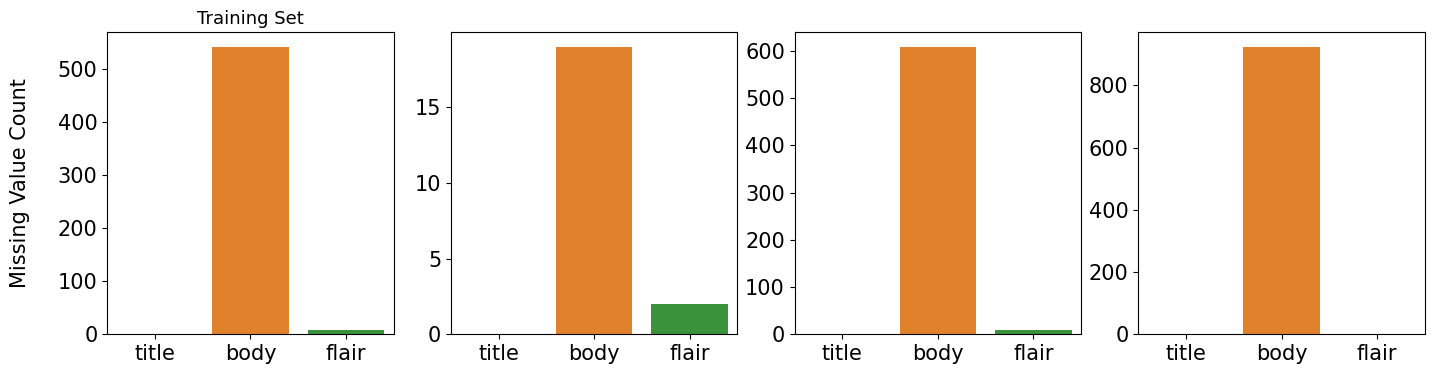

In [5]:
missing_cols = ['title', 'body', 'flair']
fig, axes = plt.subplots(ncols=4, figsize=(17, 4), dpi=100)

sns.barplot(x=hot_posts[missing_cols].isnull().sum().index, y=hot_posts[missing_cols].isnull().sum().values, ax=axes[0])
sns.barplot(x=rising_posts[missing_cols].isnull().sum().index, y=rising_posts[missing_cols].isnull().sum().values, ax=axes[1])
sns.barplot(x=new_posts[missing_cols].isnull().sum().index, y=new_posts[missing_cols].isnull().sum().values, ax=axes[2])
sns.barplot(x=top_posts[missing_cols].isnull().sum().index, y=top_posts[missing_cols].isnull().sum().values, ax=axes[3])

axes[0].set_ylabel('Missing Value Count', size=15, labelpad=20)
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)
axes[2].tick_params(axis='x', labelsize=15)
axes[2].tick_params(axis='y', labelsize=15)
axes[3].tick_params(axis='x', labelsize=15)
axes[3].tick_params(axis='y', labelsize=15)


axes[0].set_title('Training Set', fontsize=13)

plt.show()

**Most of the data in body part is null, and Flair value is also Null in rows. So we need to take care of it. Let's find out unique keyword present in our data.**

In [6]:
print(f'Number of unique values in keyword = {hot_posts["body"].nunique()} (hot_posts) - {rising_posts["body"].nunique()} (rising_posts) - {new_posts["body"].nunique()} (new_posts) - {top_posts["body"].nunique()} (top_posts)')

Number of unique values in keyword = 207 (hot_posts) - 6 (rising_posts) - 251 (new_posts) - 64 (top_posts)


In [7]:
print(f'Number of unique values in flair = {hot_posts["flair"].nunique()} (hot_posts) - {rising_posts["flair"].nunique()} (rising_posts) - {new_posts["flair"].nunique()} (new_posts) - {top_posts["flair"].nunique()} (top_posts)')


Number of unique values in flair = 14 (hot_posts) - 7 (rising_posts) - 15 (new_posts) - 35 (top_posts)


**Now, We will analyse all csv files one by one to find whether they are balanced or not.** 

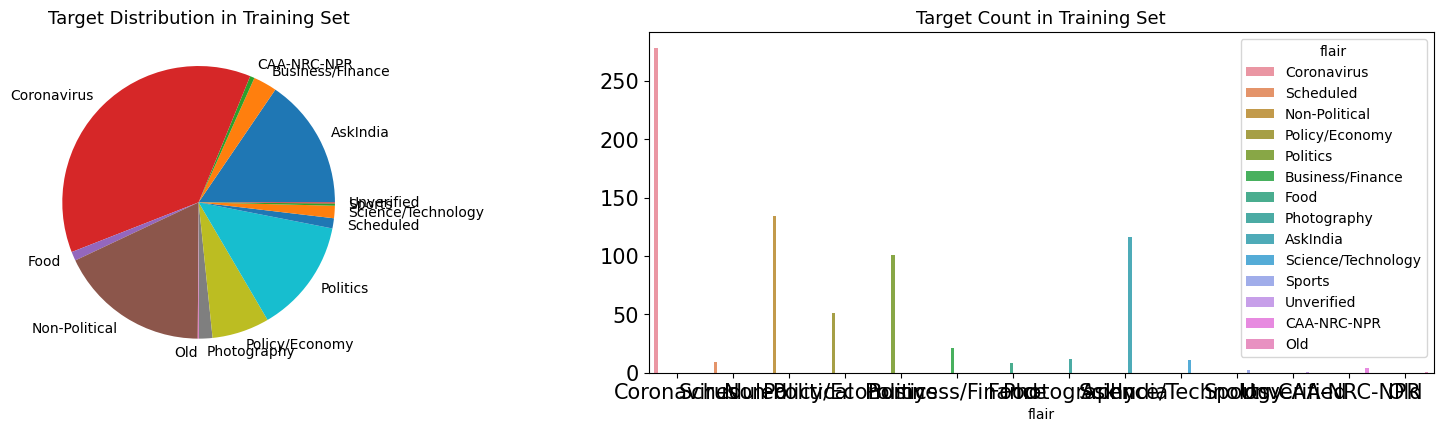

In [8]:
fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=100)
plt.tight_layout()

hot_posts.groupby('flair').count()['title'].plot(kind='pie', ax=axes[0])
sns.countplot(x=hot_posts['flair'], hue=hot_posts['flair'], ax=axes[1])

axes[0].set_ylabel('')
axes[1].set_ylabel('')
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

axes[0].set_title('Target Distribution in Training Set', fontsize=13)
axes[1].set_title('Target Count in Training Set', fontsize=13)

plt.show()

**Hot-Posts is having majorly three flair 'AskIndia', 'Coronavirus' and 'Non-Political'.**

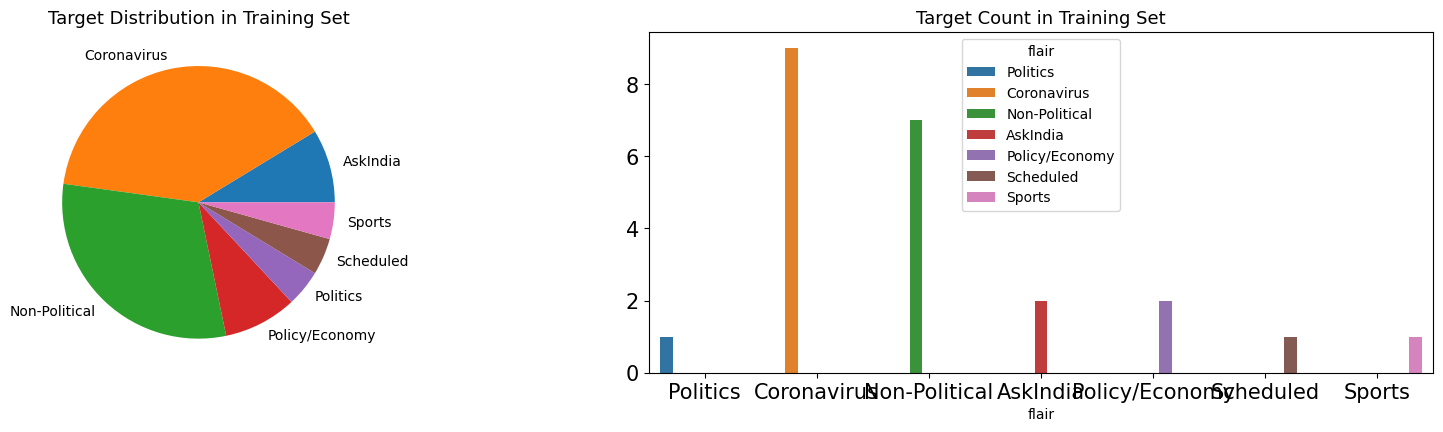

In [9]:
fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=100)
plt.tight_layout()

rising_posts.groupby('flair').count()['title'].plot(kind='pie', ax=axes[0])
sns.countplot(x=rising_posts['flair'], hue=rising_posts['flair'], ax=axes[1])

axes[0].set_ylabel('')
axes[1].set_ylabel('')
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

axes[0].set_title('Target Distribution in Training Set', fontsize=13)
axes[1].set_title('Target Count in Training Set', fontsize=13)

plt.show()

**Rising-posts is having majorly two flairs only- Coronavirus and Non-Political.** 

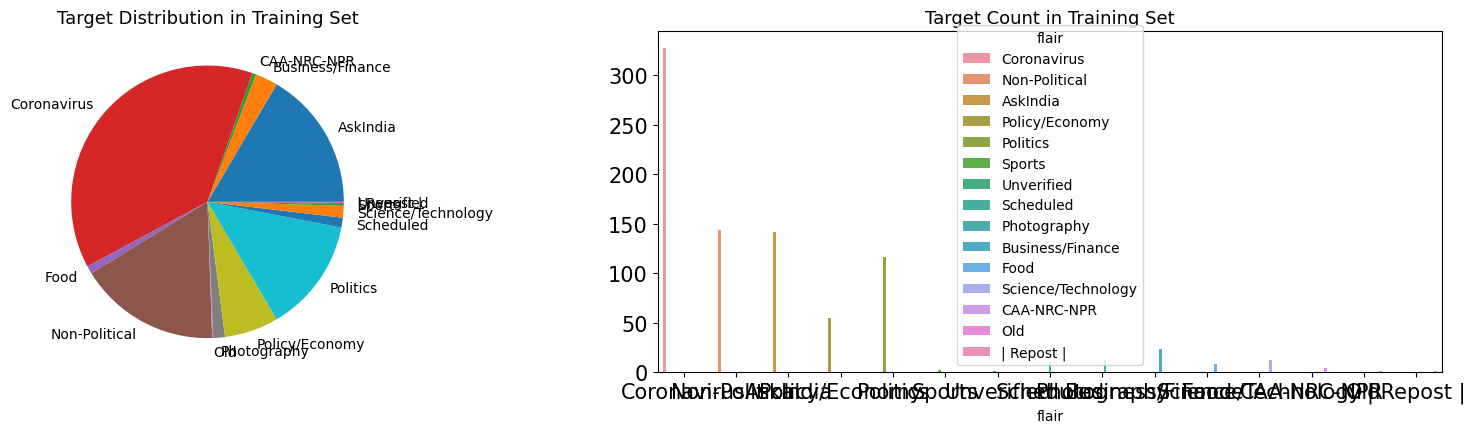

In [10]:
fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=100)
plt.tight_layout()

new_posts.groupby('flair').count()['title'].plot(kind='pie', ax=axes[0])
sns.countplot(x=new_posts['flair'], hue=new_posts['flair'], ax=axes[1])

axes[0].set_ylabel('')
axes[1].set_ylabel('')
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

axes[0].set_title('Target Distribution in Training Set', fontsize=13)
axes[1].set_title('Target Count in Training Set', fontsize=13)

plt.show()

**Similar to Hot-Posts, New-Posts is also having mainly four flair 'AskIndia', 'Coronavirus', 'Politics' and 'Non-Political'.**

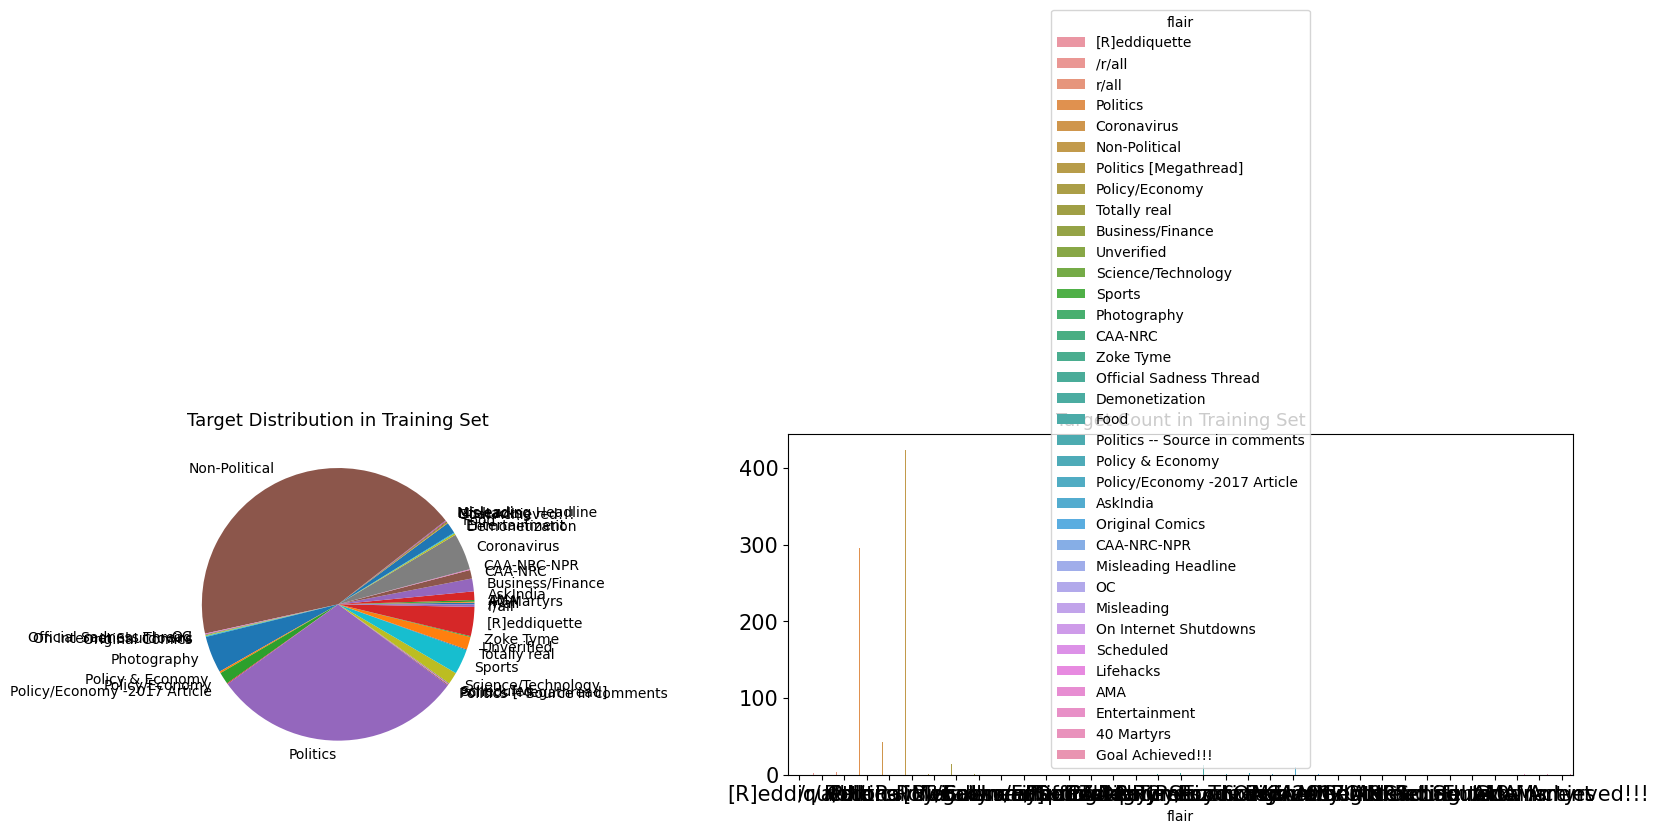

In [11]:
fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=100)
plt.tight_layout()

top_posts.groupby('flair').count()['title'].plot(kind='pie', ax=axes[0])
sns.countplot(x=top_posts['flair'], hue=top_posts['flair'], ax=axes[1])

axes[0].set_ylabel('')
axes[1].set_ylabel('')
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

axes[0].set_title('Target Distribution in Training Set', fontsize=13)
axes[1].set_title('Target Count in Training Set', fontsize=13)

plt.show()

**Top-Posts is also having mainly two flairs 'Non-Political' and 'Politics'.**

**The code below is for finding out top hundred unigrams, bigrams and trigrams prsent in textual data. In these file we are showing results for Hot-posts only, others can be similarly obtained. We are choosing three classes of flairs AskIndia, Coronavirus and Non-Political, as they are maximum in Hot-posts.** 

In [0]:
def generate_ngrams(text, n_gram=1):
    token = [token for token in str(text).lower().split(' ') if token != '' if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

N = 100

# Unigrams
askindia_unigrams = defaultdict(int)
coronavirus_unigrams = defaultdict(int)
nonpolitical_unigrams = defaultdict(int)

AskIndia = hot_posts['flair'] == 'AskIndia'
Coronavirus = hot_posts['flair'] == 'Coronavirus'
NonPolitical = hot_posts['flair'] == 'Non-Political'

for text in hot_posts[AskIndia]['body']:
    for word in generate_ngrams(text):
        askindia_unigrams[word] += 1
        
for text in hot_posts[Coronavirus]['body']:
    for word in generate_ngrams(text):
        coronavirus_unigrams[word] += 1

for text in hot_posts[NonPolitical]['body']:
    for word in generate_ngrams(text):
        nonpolitical_unigrams[word] += 1
        
df_askindia_unigrams = pd.DataFrame(sorted(askindia_unigrams.items(), key=lambda x: x[1])[::-1])
df_coronavirus_unigrams = pd.DataFrame(sorted(coronavirus_unigrams.items(), key=lambda x: x[1])[::-1])
df_nonpolitical_unigrams = pd.DataFrame(sorted(nonpolitical_unigrams.items(), key=lambda x: x[1])[::-1])

# Bigrams
askindia_bigrams = defaultdict(int)
coronavirus_bigrams = defaultdict(int)
nonpolitical_bigrams = defaultdict(int)

for text in hot_posts[AskIndia]['body']:
    for word in generate_ngrams(text, n_gram=2):
        askindia_bigrams[word] += 1
        
for text in hot_posts[Coronavirus]['body']:
    for word in generate_ngrams(text, n_gram=2):
        coronavirus_bigrams[word] += 1

for text in hot_posts[NonPolitical]['body']:
    for word in generate_ngrams(text, n_gram=2):
        nonpolitical_bigrams[word] += 1
        
df_askindia_bigrams = pd.DataFrame(sorted(askindia_bigrams.items(), key=lambda x: x[1])[::-1])
df_coronavirus_bigrams = pd.DataFrame(sorted(coronavirus_bigrams.items(), key=lambda x: x[1])[::-1])
df_nonpolitical_bigrams = pd.DataFrame(sorted(nonpolitical_bigrams.items(), key=lambda x: x[1])[::-1])

# Trigrams
askindia_trigrams = defaultdict(int)
coronavirus_trigrams = defaultdict(int)
nonpolitical_trigrams = defaultdict(int)

for text in hot_posts[AskIndia]['body']:
    for word in generate_ngrams(text, n_gram=3):
        askindia_trigrams[word] += 1
        
for text in hot_posts[Coronavirus]['body']:
    for word in generate_ngrams(text, n_gram=3):
        coronavirus_trigrams[word] += 1

for text in hot_posts[NonPolitical]['body']:
    for word in generate_ngrams(text, n_gram=3):
        nonpolitical_trigrams[word] += 1
        
df_askindia_trigrams = pd.DataFrame(sorted(askindia_trigrams.items(), key=lambda x: x[1])[::-1])
df_coronavirus_trigrams = pd.DataFrame(sorted(coronavirus_trigrams.items(), key=lambda x: x[1])[::-1])
df_nonpolitical_trigrams = pd.DataFrame(sorted(nonpolitical_trigrams.items(), key=lambda x: x[1])[::-1])


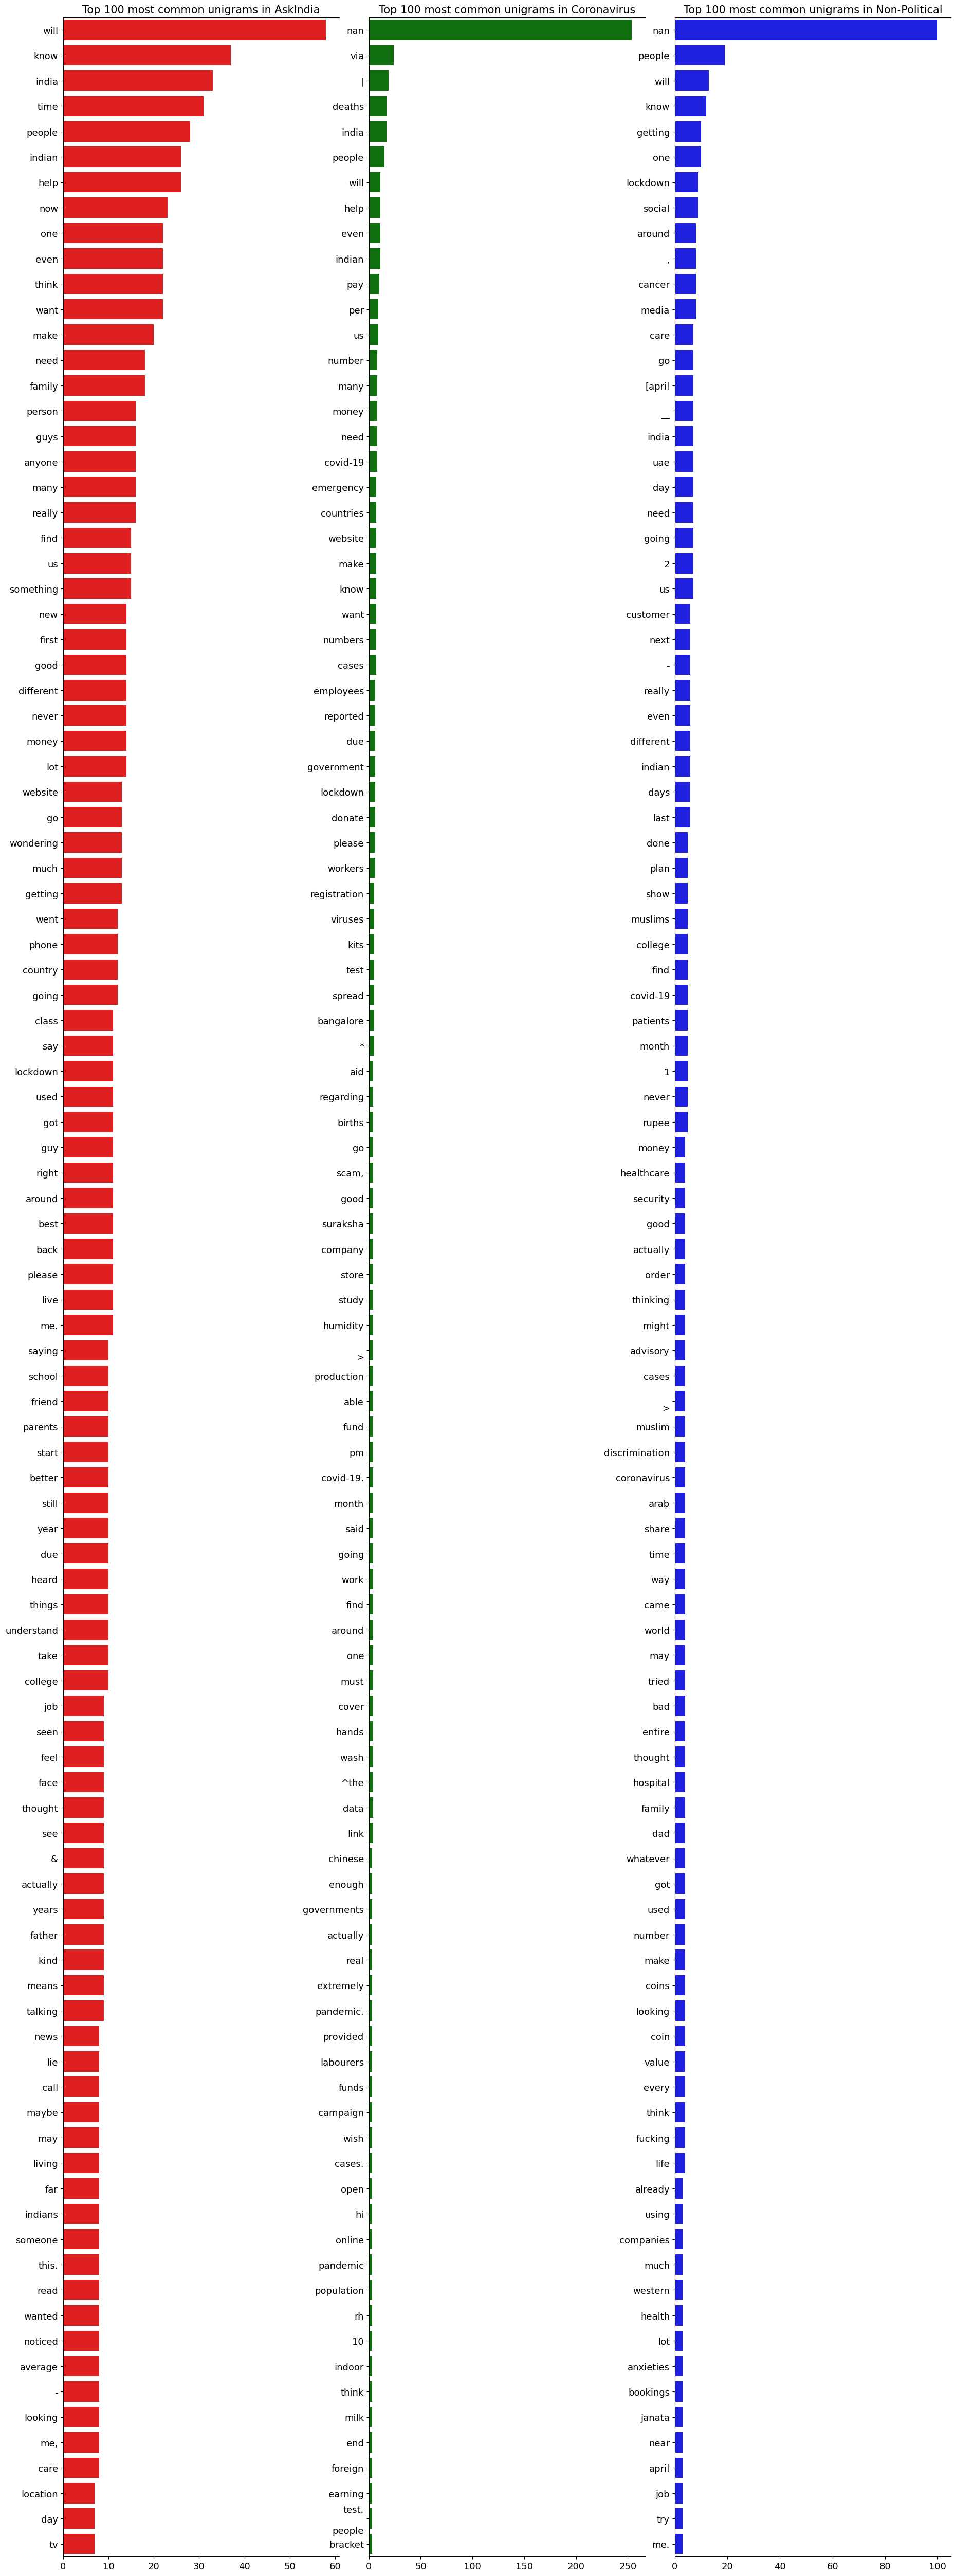

In [20]:
fig, axes = plt.subplots(ncols=3, figsize=(18, 50), dpi=100)
plt.tight_layout()

sns.barplot(y=df_askindia_unigrams[0].values[:N], x=df_askindia_unigrams[1].values[:N], ax=axes[0], color='red')
sns.barplot(y=df_coronavirus_unigrams[0].values[:N], x=df_coronavirus_unigrams[1].values[:N], ax=axes[1], color='green')
sns.barplot(y=df_nonpolitical_unigrams[0].values[:N], x=df_nonpolitical_unigrams[1].values[:N], ax=axes[2], color='blue')

for i in range(3):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

axes[0].set_title(f'Top {N} most common unigrams in AskIndia', fontsize=15)
axes[1].set_title(f'Top {N} most common unigrams in Coronavirus', fontsize=15)
axes[2].set_title(f'Top {N} most common unigrams in Non-Political', fontsize=15)

plt.show()

**Unigrams can be used in our model because there are less number of unigrams present that are common in all three flair-category. **

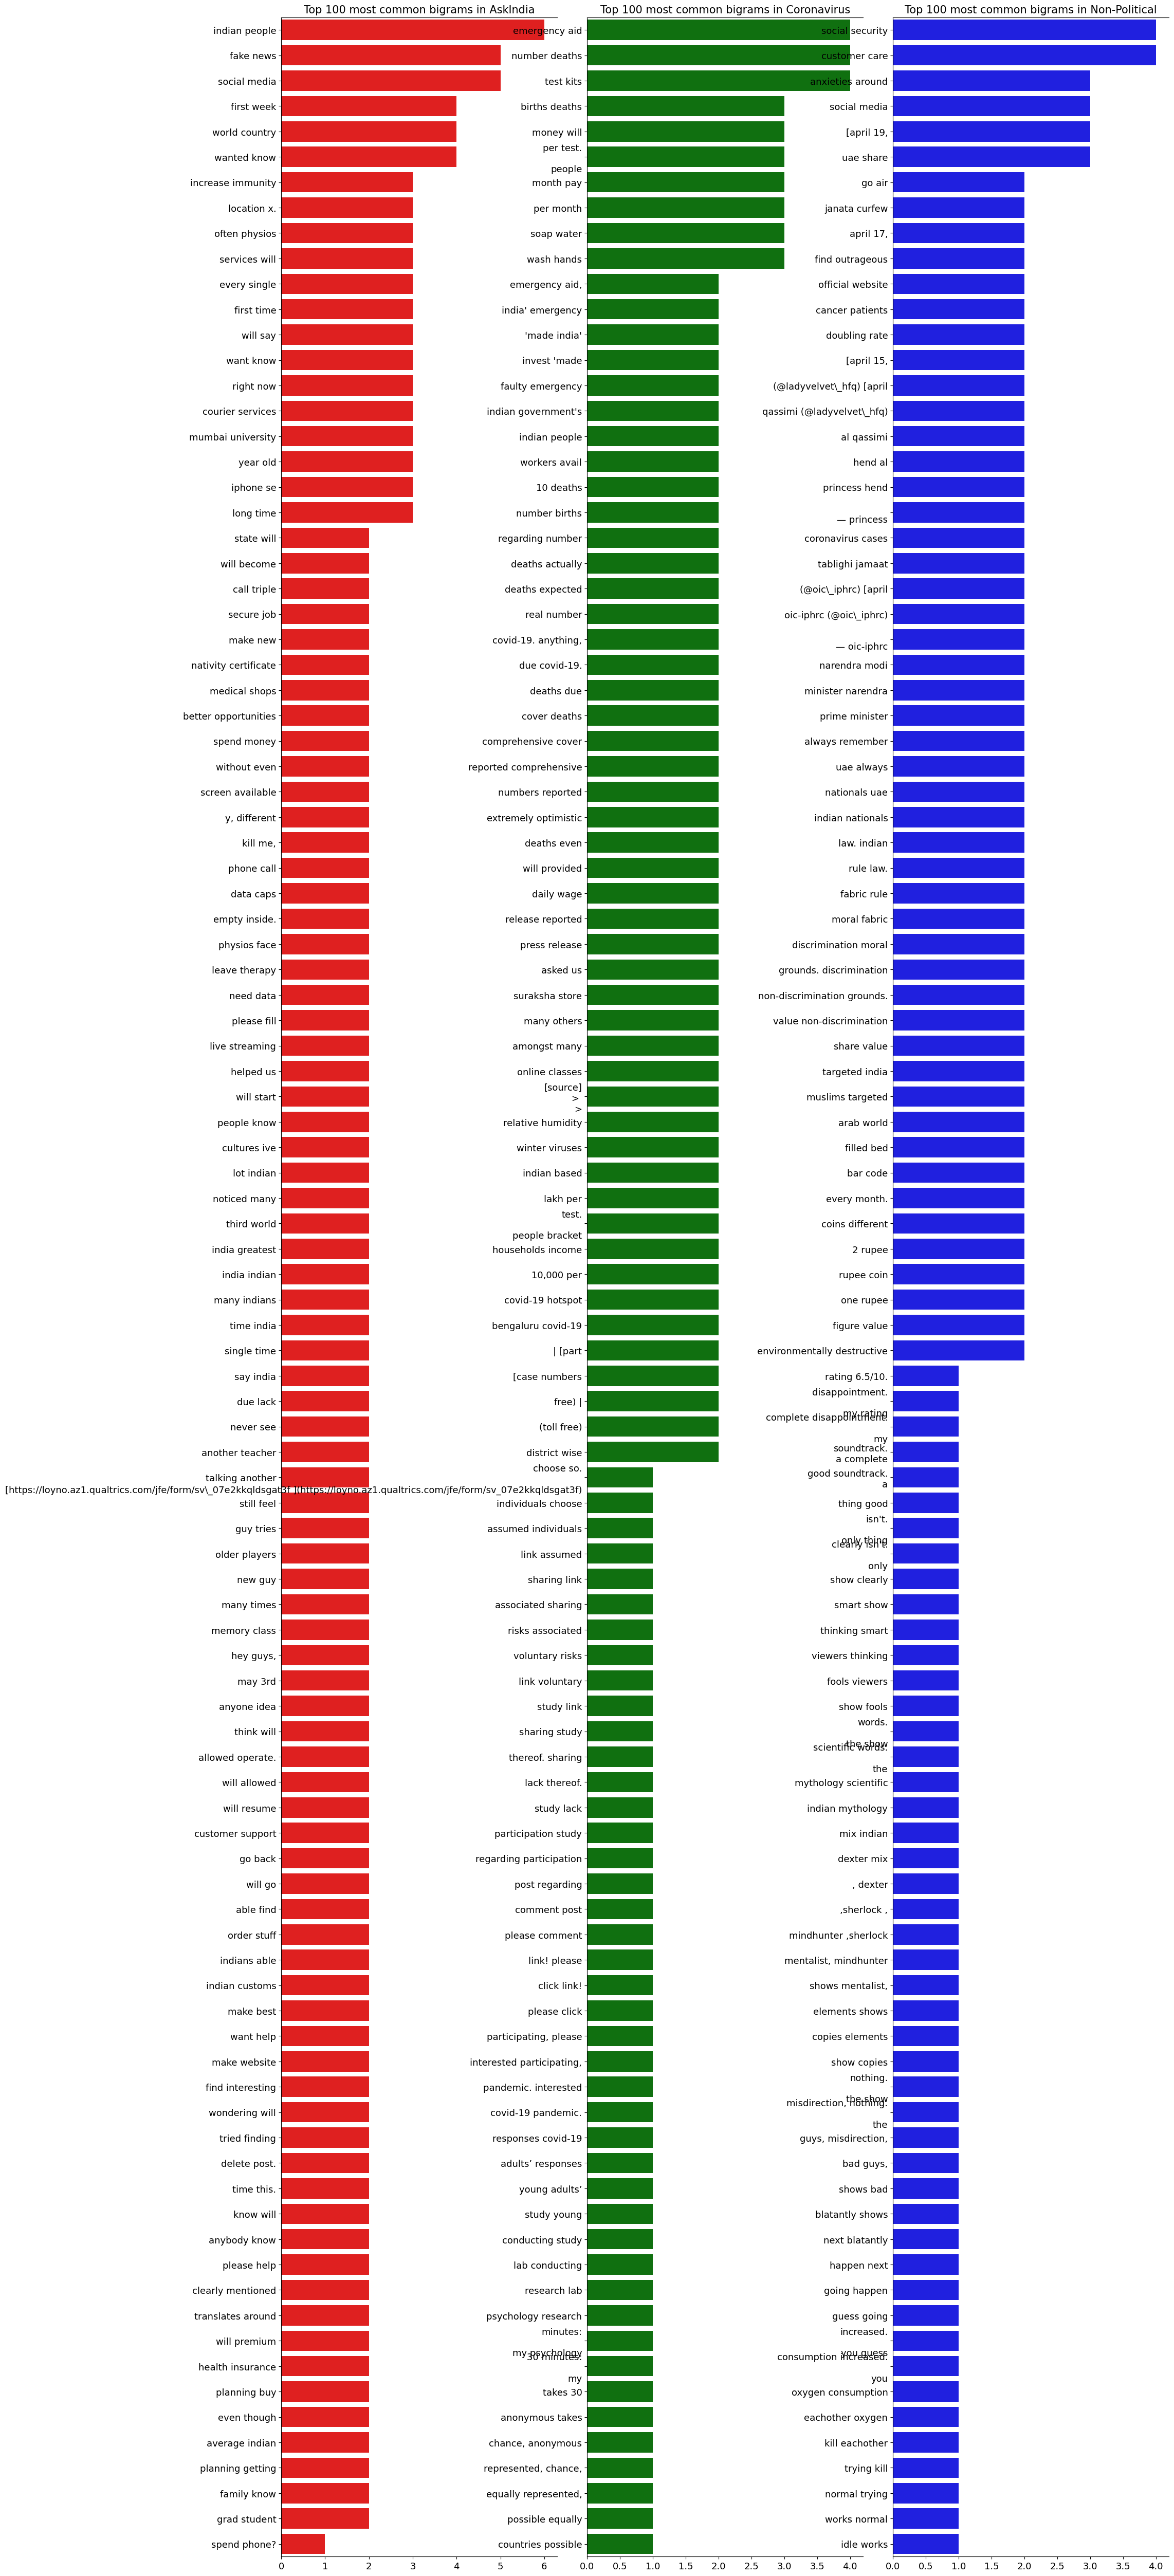

In [21]:
fig, axes = plt.subplots(ncols=3, figsize=(18, 50), dpi=100)
plt.tight_layout()

sns.barplot(y=df_askindia_bigrams[0].values[:N], x=df_askindia_bigrams[1].values[:N], ax=axes[0], color='red')
sns.barplot(y=df_coronavirus_bigrams[0].values[:N], x=df_coronavirus_bigrams[1].values[:N], ax=axes[1], color='green')
sns.barplot(y=df_nonpolitical_bigrams[0].values[:N], x=df_nonpolitical_bigrams[1].values[:N], ax=axes[2], color='blue')

for i in range(3):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

axes[0].set_title(f'Top {N} most common bigrams in AskIndia', fontsize=15)
axes[1].set_title(f'Top {N} most common bigrams in Coronavirus', fontsize=15)
axes[2].set_title(f'Top {N} most common bigrams in Non-Political', fontsize=15)

plt.show()

**Most of the bigrams are different for each class.** 

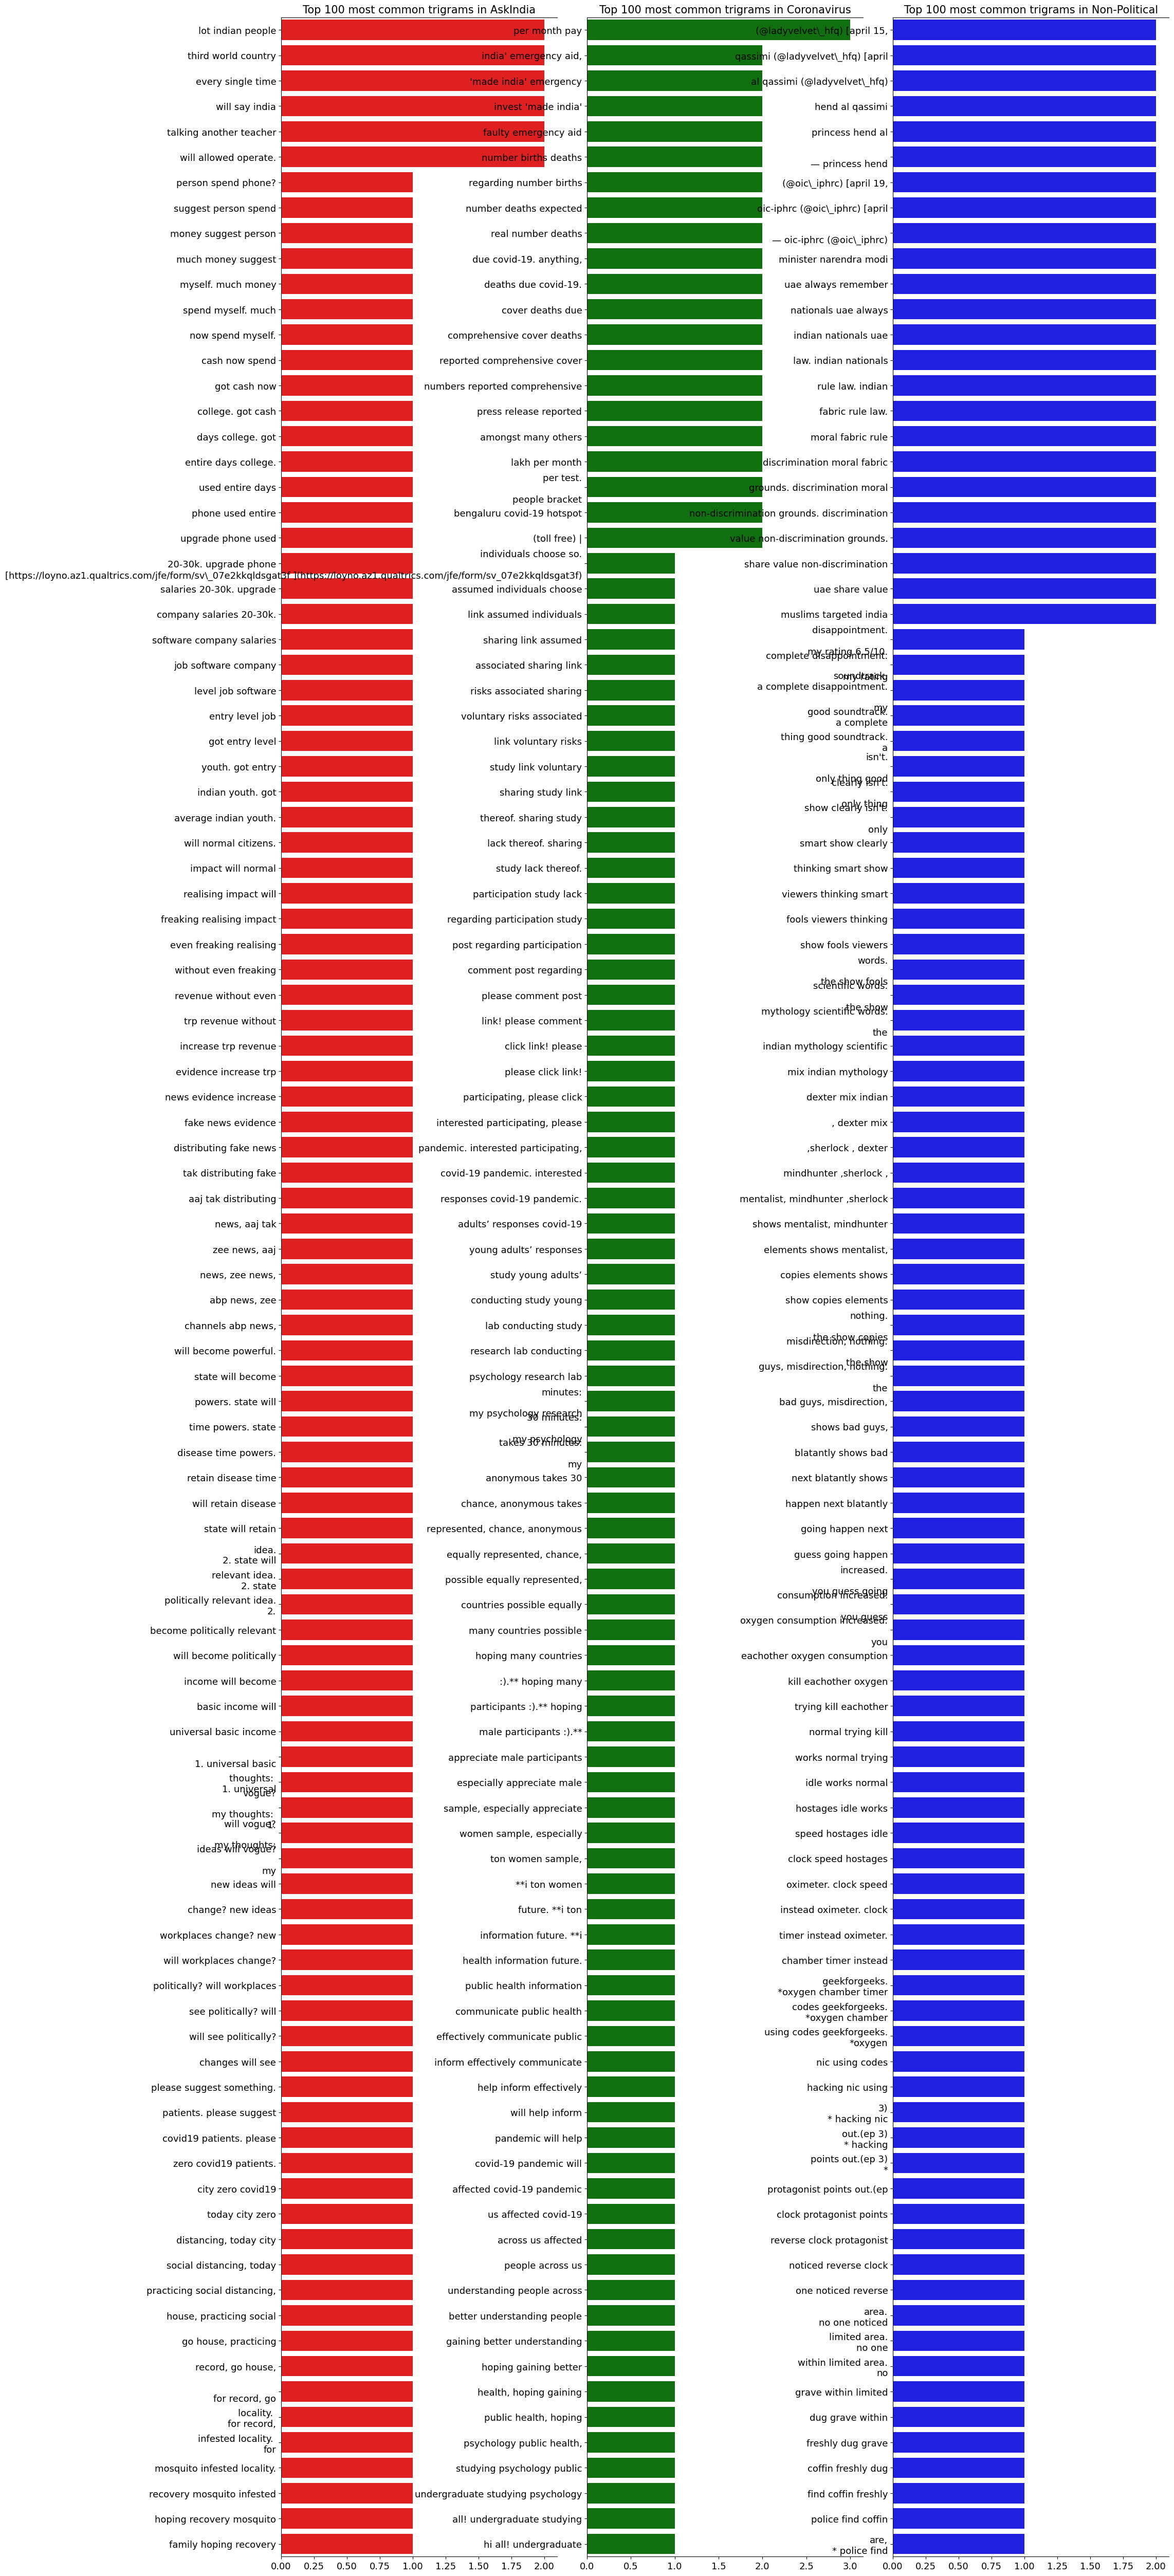

In [22]:
fig, axes = plt.subplots(ncols=3, figsize=(18, 50), dpi=100)
plt.tight_layout()

sns.barplot(y=df_askindia_trigrams[0].values[:N], x=df_askindia_trigrams[1].values[:N], ax=axes[0], color='red')
sns.barplot(y=df_coronavirus_trigrams[0].values[:N], x=df_coronavirus_trigrams[1].values[:N], ax=axes[1], color='green')
sns.barplot(y=df_nonpolitical_trigrams[0].values[:N], x=df_nonpolitical_trigrams[1].values[:N], ax=axes[2], color='blue')

for i in range(3):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

axes[0].set_title(f'Top {N} most common trigrams in AskIndia', fontsize=15)
axes[1].set_title(f'Top {N} most common trigrams in Coronavirus', fontsize=15)
axes[2].set_title(f'Top {N} most common trigrams in Non-Political', fontsize=15)

plt.show()

**As unigrams and bigrams are different in nature for all choosen class, trigrams should also be different, which has been shown above. **

**Now combine all the four dataframes into single one as posts.**

In [41]:
posts = pd.concat([hot_posts, rising_posts, new_posts, top_posts])
posts.flair.value_counts()

Non-Political                     708
Coronavirus                       658
Politics                          513
AskIndia                          270
Policy/Economy                    122
Photography                        67
Business/Finance                   59
Science/Technology                 37
[R]eddiquette                      34
Sports                             34
Food                               29
Scheduled                          21
Unverified                         17
CAA-NRC                            10
CAA-NRC-NPR                         9
r/all                               3
Policy & Economy                    2
AMA                                 2
/r/all                              2
Old                                 2
Demonetization                      2
OC                                  1
Misleading                          1
On Internet Shutdowns               1
Totally real                        1
Politics [Megathread]               1
Politics -- 

In [42]:
posts['body'].isnull().sum()  
# Number of rows having value of body as NULL

2095

In [0]:
posts['body'].fillna('No_text', inplace=True)
# Fill those rows with 'No_text', later we will remove this from our data while cleaning data.

In [44]:
posts.shape


(2640, 3)

In [0]:
posts = posts[posts['flair'].notna()]
# Dropping those rows where flair value is NULL or in other terms selecting only those rows where flair value is not NULL.

In [0]:
posts['text'] = posts['title'] + " " + posts['body']
# Combining two columns Title and Body in single one Text, because it would be easy to operate on both together. 

In [0]:
posts = posts.drop(['title', 'body'], axis=1)
# Droppig colums Title and Body, because they are unnecessary for use.

In [48]:
posts

,flair,text
0,Coronavirus,Coronavirus (COVID-19) Megathread - News and U...
1,Scheduled,"[Monthly Happiness Thread] Randians, please sh..."
3,Non-Political,Was going through my grandpa’s stuffs and foun...
4,Non-Political,Muslims are feeding you and carrying your dead...
5,Coronavirus,'100-120 million jobs lost due to COVID-19 loc...
...,...,...
983,Non-Political,Morning Scenes in my village! No_text
984,Demonetization,De-infinitising stones [NP] No_text
985,Non-Political,"""The Things I Did For Love"" (OC, Procreate, Ap..."
986,Politics,Hold it by the head and strike right into the ...


In [0]:
columns_titles = ["text","flair"]
posts=posts.reindex(columns=columns_titles)
# For sake of comfortability, text is taken first in column and Flair is second.

In [0]:
df = posts
counts = df['flair'].value_counts()
df = df[~df['flair'].isin(counts[counts < 21].index)]
# Dropping those flair with their rows which are less than 21.  

In [51]:
df.flair.value_counts() 
# How many rows present for each flair. (To know the imbalance in data)

Non-Political         708
Coronavirus           658
Politics              513
AskIndia              270
Policy/Economy        122
Photography            67
Business/Finance       59
Science/Technology     37
[R]eddiquette          34
Sports                 34
Food                   29
Scheduled              21
Name: flair, dtype: int64

**To make our data balance we are going to downsample. We have downsampled AskIndia, Coronavirus, Nonpolitical and Politics to 120 rows.**

In [0]:
df_AskIndia = df[df.flair=='AskIndia']
df_Coronavirus = df[df.flair=='Coronavirus']
df_Nonpolitical = df[df.flair=='Non-Political']
df_Politics = df[df.flair=='Politics']
df_all = df[df.flair!='AskIndia']
df_all = df_all[df_all.flair!='Coronavirus']
df_all = df_all[df_all.flair!='Non-Political']
df_all = df_all[df_all.flair!='Politics']

df_AskIndia_downsampled = resample(df_AskIndia, 
                                  replace=False,    # sample without replacement
                                  n_samples=120,     # to match minority class
                                  random_state=123)

df_Coronavirus_downsampled = resample(df_Coronavirus, 
                                 replace=False,    # sample without replacement
                                 n_samples=120,     # to match minority class
                                 random_state=123)

df_Nonpolitical_downsampled = resample(df_Nonpolitical, 
                                 replace=False,    # sample without replacement
                                 n_samples=120,     # to match minority class
                                 random_state=123)

df_Politics_downsampled = resample(df_Politics, 
                                 replace=False,    # sample without replacement
                                 n_samples=120,     # to match minority class
                                 random_state=123)

df_downsampled = pd.concat([df_AskIndia_downsampled, df_Coronavirus_downsampled, df_Nonpolitical_downsampled, df_Politics_downsampled, df_all])
df_downsampled.flair.value_counts()
posts = df_downsampled

In [54]:
posts.flair.value_counts()

Policy/Economy        122
AskIndia              120
Politics              120
Coronavirus           120
Non-Political         120
Photography            67
Business/Finance       59
Science/Technology     37
Sports                 34
[R]eddiquette          34
Food                   29
Scheduled              21
Name: flair, dtype: int64

In [0]:
posts.to_csv('Posts-data.csv', index=False) 
# Final dataframe is exported as Posts-data.csv